Your job is to create a regression model that will help predict how many crew members will be needed for future ships. In other words, use the features you think will be useful to predict the value in the Crew column. 

First, we need to create the Spark Session

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://mirrors.sonic.net/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xzf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark


import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"


import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Afterwards, we can read the file and inspect it

In [ ]:
#Please drop the file in the environments 'Files' panel
df = spark.read.options(header="true", inferSchema="true").csv("/content/cruise_ship_info.csv")
df.describe().toPandas()

,summary,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,count,158,158,158,158,158,158,158,158,158
1,mean,Infinity,None,15.689873417721518,71.28467088607599,18.45740506329114,8.130632911392404,8.830000000000005,39.90094936708861,7.794177215189873
2,stddev,None,None,7.615691058751413,37.229540025907866,9.677094775143416,1.793473548054825,4.4714172221480615,8.63921711391542,3.503486564627034
3,min,Adventure,Azamara,4,2.329,0.66,2.79,0.33,17.7,0.59
4,max,Zuiderdam,Windstar,48,220.0,54.0,11.82,27.0,71.43,21.0


Here, we can see that Cruise_line, which we were told is an important parameter, is an string variable. This is a problem! ML algorithms work better with numbers, as it is unclear how to process a string. ¿The solution? We can index the Cruise_line!

Source: [Stack Overflow](https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

#Bonus! Change this code to index multiple columns at once!
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in list(["Cruise_line"]) ]


pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)
df_indexed.describe().toPandas()

,summary,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew,Cruise_line_index
0,count,158,158,158,158,158,158,158,158,158,158
1,mean,Infinity,None,15.689873417721518,71.28467088607599,18.45740506329114,8.130632911392404,8.830000000000005,39.90094936708861,7.794177215189873,5.063291139240507
2,stddev,None,None,7.615691058751413,37.229540025907866,9.677094775143416,1.793473548054825,4.4714172221480615,8.63921711391542,3.503486564627034,4.758744608182735
3,min,Adventure,Azamara,4,2.329,0.66,2.79,0.33,17.7,0.59,0.0
4,max,Zuiderdam,Windstar,48,220.0,54.0,11.82,27.0,71.43,21.0,19.0


Of course, the mean and stdev values for Cruise_line_index are pointless, since they just represent the Cruise Operator Company; BUT! they help us understand the data, since we can now use pandas to do a quick check among numeric variables, and see if they are related or not (source: [TowardsDataScience](https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a))

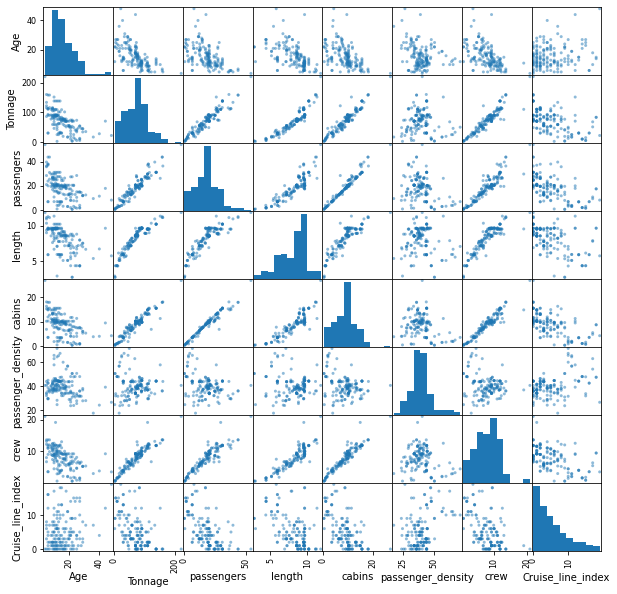

In [ ]:
import pandas as pd
#Fun but interesting fact: if you add ";" at the end of your command, you dont get matplotlib axes warnings! Yuhuuu!
pd.plotting.scatter_matrix(df_indexed.toPandas(), figsize=(10, 10));

We can see that there are some variables which show very good correlation between them, such as passenger number and number of cabins; this makes sense, and can be used as "intuitive proof" that we are doing something correctly. 

With regard to our parameter of interest, crew, we see that it seems to be most closely relate to tonnage and number of cabins, another common sense, intuitive deduction, since bigger ships need more crew to manage them and to guide the customers. 

Crusise_line index doesnt seem to be very related to crew, but this could be an artifact caused by the ordering of the data in decreasing order of Cruse_line_index in the graph; with numeric correlation, a similar problem could arise, since, for potential correlation, we would expect the highest index (19) to have highest values. I will thus continue using the parameter on the model, as I was asked, and see what happens :p



Now that we have done an initial exploratory analysis on the data, lets try to generate a ML model using pyspark that tells us which characteristics here are most important:

In [ ]:
from pyspark.ml.feature import VectorAssembler
#By using a list comprehension we can define inputcols as the exclusion of some columns from df_indexed
assembler = VectorAssembler(inputCols= [e for e in df_indexed.columns if e not in ('Ship_name', 'Cruise_line', 'crew')]  , outputCol='features', 
                            handleInvalid='skip')
output = assembler.transform(df_indexed)

In [ ]:
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=['crew'], outputCols=['label'], strategy='mean')
imputer_model = imputer.fit(output)
output = imputer_model.transform(output)

Just to be sure everything went correctly in our pipeline, lets show the output dataframe:

In [ ]:
output.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+--------------------+-----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_index|            features|label|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+--------------------+-----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|[6.0,30.276999999...| 3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|[6.0,30.276999999...| 3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|              1.0|[26.0,47.262,14.8...|  6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|              1.0|[11.0,110.0,29.74...| 19.1|
|    D

Nice! As we can see, we have all our expected columns (the ones in the matrix except those in the list comprehension), and two new ones: features, which is what Spark will use for its ML approach, and label, which is populated with the crew values and will help us predict it.

In [ ]:
#Lets select the data we want to use:
final_data = output.select(['features', 'label'])

We can now divide the data in two: a training dataset and a test dataset, which will be used to validate the conclussions of our trained data. For the process to work, sampling has to be random, so that no undue influence is exerted through data selection (say, if we picked the first 20 values); and, the data has to be divided somehow: here, we create an 65/35 split because I felt like 70/30 left too few individuals in the test data category

In [ ]:
train_data, test_data = final_data.randomSplit([0.65, 0.35])

In [ ]:
final_data.describe().show(), train_data.describe().show(), test_data.describe().show()

+-------+-----------------+
|summary|            label|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               104|
|   mean| 7.825096153846162|
| stddev|3.4947555702107467|
|    min|               0.6|
|    max|              21.0|
+-------+------------------+

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|                54|
|   mean|  7.73462962962963|
| stddev|3.5523607420094137|
|    min|              0.59|
|    max|              13.6|
+-------+------------------+



(None, None, None)

In [ ]:
#We import the ML Linear Regression module and stablish the label
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol='label')

In [ ]:
lr_model = lr.fit(train_data)

In [ ]:
test_results = lr_model.evaluate(test_data)

In [ ]:
#The residuals for an observation is the difference between the observation (the y-value) and the fitted line.
test_results.residuals.show()
#And the root Mean Squared Error is a meassure of accuracy
test_results.rootMeanSquaredError

+--------------------+
|           residuals|
+--------------------+
| -1.3259944983423733|
| -0.8514434688157184|
| 0.25203246173775007|
| -0.5786778245997795|
| 0.17444151538670027|
| -1.3832902288430144|
| -0.8158551082693961|
| -0.4427713845911221|
|  0.3604712596502839|
| -0.6603995683195034|
|-0.25945919107257787|
|  0.3813308210539432|
| -0.7477823634981888|
|  0.6855294216709122|
| -0.6200715933698913|
| -0.7413835788890388|
| -0.6541795737066902|
|  0.9199379275910768|
|  0.9199379275910768|
| -0.4181630087049122|
+--------------------+
only showing top 20 rows



0.6939264035154783

Well... it seems like we dont get reeeealy good values. Lets check the R² just in case...

In [ ]:
test_results.r2

0.9611214023707688

Woah! That's a big R² !I guess our results were not so bad after all!!

Lets see the predictions then!

In [ ]:
lr_model.transform(test_data).show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[5.0,86.0,21.04,9...|  8.0| 9.325994498342373|
|[6.0,30.276999999...| 3.55| 4.401443468815718|
|[6.0,110.23899999...| 11.5| 11.24796753826225|
|[6.0,112.0,38.0,9...| 10.9| 11.47867782459978|
|[6.0,113.0,37.82,...| 12.0|  11.8255584846133|
|[7.0,89.6,25.5,9....| 9.87|11.253290228843014|
|[7.0,116.0,31.0,9...| 12.0|12.815855108269396|
|[7.0,158.0,43.7,1...| 13.6|14.042771384591122|
|[8.0,77.499,19.5,...|  9.0| 8.639528740349716|
|[8.0,110.0,29.74,...| 11.6|12.260399568319503|
|[9.0,59.058,17.0,...|  7.4| 7.659459191072578|
|[9.0,81.0,21.44,9...| 10.0| 9.618669178946057|
|[9.0,85.0,19.68,9...| 8.69| 9.437782363498188|
|[9.0,88.5,21.24,9...| 10.3| 9.614470578329088|
|[9.0,90.09,25.01,...| 8.69|  9.31007159336989|
|[9.0,105.0,27.2,8...|10.68|11.421383578889039|
|[9.0,110.0,29.74,...| 11.6| 12.25417957370669|
|[9.0,113.0,26.74,...|12.38|11.460062072

Thats it! We have a LR, ML model that accurately (0.96) predicts the number of crew members in a Cruise ship. However, ¿could we do better? If we look back at the scatter matrix, we see that some values related better to crew than others. By excluding them, could we increase the models accuracy?

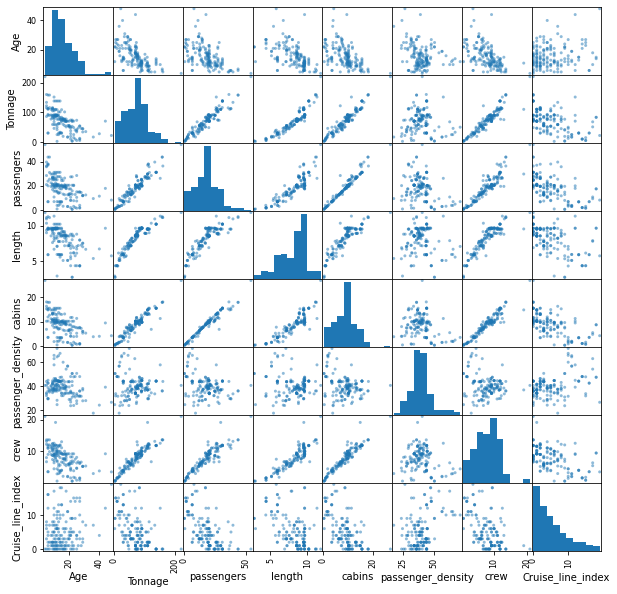

In [ ]:
pd.plotting.scatter_matrix(df_indexed.toPandas(), figsize=(10, 10));

Lets try to remove passenger_density, Age and Cruise_line_index (even though yes, we were told this was an important parameter for the company) and see what happens:

In [ ]:
assembler = VectorAssembler(inputCols= [e for e in df_indexed.columns if e not in ('Ship_name', 'Cruise_line', 
                                                                                   'crew', 'passenger_density', 'Age', 'Cruise_line_index')]  , outputCol='features', 
                            handleInvalid='skip')
output = assembler.transform(df_indexed)

In [ ]:
imputer = Imputer(inputCols=['crew'], outputCols=['label'], strategy='mean')
imputer_model = imputer.fit(output)
output = imputer_model.transform(output)

In [ ]:
final_data = output.select(['features', 'label'])

In [ ]:
train_data, test_data = final_data.randomSplit([0.65, 0.35])

In [ ]:
lr = LinearRegression(labelCol='label')
lr_model = lr.fit(train_data)
test_results = lr_model.evaluate(test_data)

In [ ]:
test_results.residuals.show(), test_results.rootMeanSquaredError, test_results.r2

+--------------------+
|           residuals|
+--------------------+
| -0.8231610867408612|
| -0.2639915612753747|
| -0.1339915612753746|
| -0.1943057005996871|
|-0.22359048492732336|
|-0.41929365405413854|
| 0.01972284792550294|
|-0.05123127867500...|
| 0.08804027838669004|
|-0.09625319517634523|
| -0.2464422157023174|
|  0.6476692405794164|
| 0.11971319676579384|
|  1.2077329156434358|
|  0.2875155279976793|
| -1.0783646108913167|
| -0.1617301231003614|
| -0.1617301231003614|
| -0.6314669369748263|
|-0.44057575750874367|
+--------------------+
only showing top 20 rows



(None, 0.9260213023938995, 0.9148216903559475)

Wow!  When we do this supposed "optimisation" of the model, we can see that, while the R² is not so different (0.91 vs 0.96, an **acceptable** decrease), the RMSD grows **massively** (from 0.69 to 0.92). And, given that **an smaller RMSD is better** this change in the model can be deemed unacceptable: all the characteristics **together** predict crew members better that when taking some of them out.

A PCA approach could help us define which parameters are the most important for the model in a more 'mathematic' way, but, for the time being, we will keep the first model: an R² of 0.96 is good enough, I believe.